In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot

from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.api import qqplot

In [2]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

def r2_score2(y_true, y_pred, ts):
    mu = np.mean(ts)
    total = np.sum((y_true - mu) ** 2)
    residuals = np.sum((y_true - y_pred) ** 2)
    return 1 - (residuals / total)


def absolute_percentage_error(y_true, y_pred):
    return np.abs((y_true - y_pred) / y_pred)


def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(absolute_percentage_error(y_true, y_pred))


def max_absolute_percentage_error(y_true, y_pred):
    return np.max(absolute_percentage_error(y_true, y_pred))


def total_absolute_percentage_error(y_true, y_pred):
    return np.sum(absolute_percentage_error(y_true, y_pred))


def evaluate(y_true, y_pred, ts):
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAD': median_absolute_error(y_true, y_pred),
        'R2': r2_score2(y_true, y_pred, ts),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred),
        'MAXAPE': max_absolute_percentage_error(y_true, y_pred),
        'TAPE': total_absolute_percentage_error(y_true, y_pred),
        'RealR2': r2_score(y_true, y_pred)
    }

In [3]:
#Si passa la time series e la dimensione della finestra
def test_stationarity(timeseries, w):

    #Determing rolling statistics
    rolmean = timeseries.rolling(w).mean()#pd.rolling_mean(timeseries, window=w)
    rolstd = timeseries.rolling(w).std()#pd.rolling_std(timeseries, window=w)
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.xticks(rotation=45)
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

Funzione per effettuare l'Augmented Dickey Fuller Test

Il Dickey-Fuller test valuta se le timeseries hanno una struttura dipendente dal tempo (non stazionaria, ovvero influenzata da tendenza, stagionalità e altri fenomeni che fanno variare le statistiche delle time series nel tempo) o meno (stazionaria), che sono legate a (sebbene abbastanza diverso da) periodicità e autocorrelazione.

In [4]:
def adf_test(timeseries):
    print("Risultati del DIckey-Fuller Test:")
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

Funzione per effettuare il KPSS Test (Kwiatkowski-Phillips-Schmidt-Shin)

In [5]:
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key, value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print(kpss_output)

In [6]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d %H:%M:%S')
df_C_Giovedi = pd.read_csv('TimeSeries_DataSet/CO2/CO2_Giovedi_1.csv', parse_dates=True, index_col='date', date_parser=dateparse)
df_C_Venerdi = pd.read_csv('TimeSeries_DataSet/CO2/CO2_Venerdi_1.csv', parse_dates=True, index_col='date', date_parser=dateparse)
df_C_Sabato = pd.read_csv('TimeSeries_DataSet/CO2/CO2_Sabato_1.csv', parse_dates=True, index_col='date', date_parser=dateparse)
df_C_Domenica = pd.read_csv('TimeSeries_DataSet/CO2/CO2_Domenica_1.csv', parse_dates=True, index_col='date', date_parser=dateparse)
df_C_Lunedi = pd.read_csv('TimeSeries_DataSet/CO2/CO2_Lunedi_1.csv', parse_dates=True, index_col='date', date_parser=dateparse)

In [7]:
df_T_Giovedi = pd.read_csv('TimeSeries_DataSet/Temperature/Temperature_Giovedi_1.csv', parse_dates=True, index_col='date', date_parser=dateparse)
df_T_Venerdi = pd.read_csv('TimeSeries_DataSet/Temperature/Temperature_Venerdi_1.csv', parse_dates=True, index_col='date', date_parser=dateparse)
df_T_Sabato = pd.read_csv('TimeSeries_DataSet/Temperature/Temperature_Sabato_1.csv', parse_dates=True, index_col='date', date_parser=dateparse)
df_T_Domenica = pd.read_csv('TimeSeries_DataSet/Temperature/Temperature_Domenica_1.csv', parse_dates=True, index_col='date', date_parser=dateparse)
df_T_Lunedi = pd.read_csv('TimeSeries_DataSet/Temperature/Temperature_Lunedi_1.csv', parse_dates=True, index_col='date', date_parser=dateparse)

In [8]:
df_all = pd.read_csv('TimeSeries_DataSet/CO2/CO2_04to10.csv', parse_dates=True, index_col='date', date_parser=dateparse)

In [9]:
df_first = pd.read_csv('TimeSeries_DataSet/CO2/CO2_02to04.csv', parse_dates=True, index_col='date', date_parser=dateparse)

In [10]:
df_second = pd.read_csv('TimeSeries_DataSet/CO2/CO2_11to18.csv', parse_dates=True, index_col='date', date_parser=dateparse)

In [11]:
df_all_2 = pd.read_csv('TimeSeries_DataSet/Temperature/Temperature_04to10.csv', parse_dates=True, index_col='date', date_parser=dateparse)

150


c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


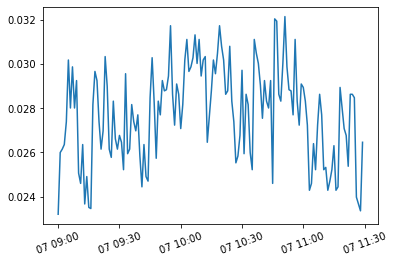

In [12]:
df_C_Sabato_Quart = df_C_Sabato[60*9:60*11+30]
ts_C_Sabato_Quart = df_C_Sabato_Quart['CO2']
print(len(ts_C_Sabato_Quart))
index = pd.date_range(start=ts_C_Sabato_Quart.index[0], end=ts_C_Sabato_Quart.index[len(ts_C_Sabato_Quart)-1], freq='1min')
ts_C_Sabato_Quart = pd.Series(ts_C_Sabato_Quart.values, index)
plt.plot(ts_C_Sabato_Quart)
plt.xticks(rotation=20)
plt.show()

2400


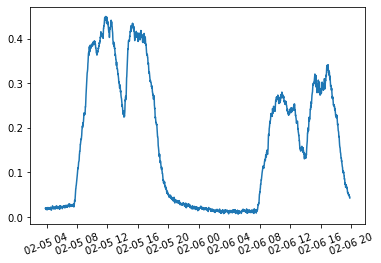

In [13]:
ts_dataset2 = df_all['CO2'][60*10:60*50]
print(len(ts_dataset2))
index = pd.date_range(start=ts_dataset2.index[0], end=ts_dataset2.index[len(ts_dataset2)-1], freq='1min')
ts_dataset2 = pd.Series(ts_dataset2.values, index)
plt.plot(ts_dataset2)
plt.xticks(rotation=20)
plt.show()

2665


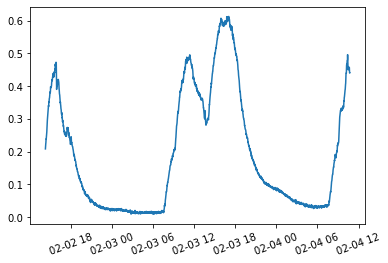

In [14]:
ts_first = df_first['CO2']
print(len(ts_first))
index = pd.date_range(start=ts_first.index[0], end=ts_first.index[len(ts_first)-1], freq='1min')
ts_first = pd.Series(ts_first.values, index)
plt.plot(ts_first)
plt.xticks(rotation=20)
plt.show()

9752


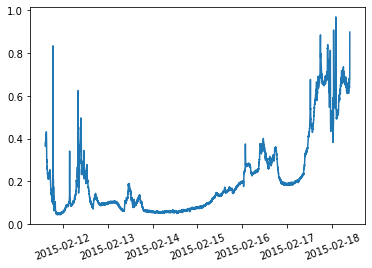

In [15]:
ts_second = df_second['CO2']
print(len(ts_second))
index = pd.date_range(start=ts_second.index[0], end=ts_second.index[len(ts_second)-1], freq='1min')
ts_first = pd.Series(ts_second.values, index)
plt.plot(ts_first)
plt.xticks(rotation=20)
plt.show()

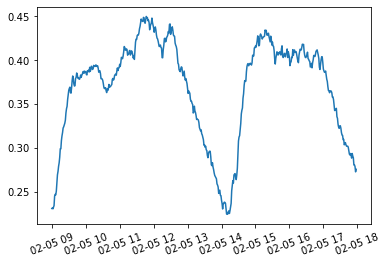

In [16]:
df_C_Giovedi_Half = df_C_Giovedi[60*9:60*18]
ts_C_Giovedi_Halft = df_C_Giovedi_Half['CO2']

index = pd.date_range(start=ts_C_Giovedi_Halft.index[0], end=ts_C_Giovedi_Halft.index[len(ts_C_Giovedi_Halft)-1], freq='1min')
ts_C_Giovedi_Halft = pd.Series(ts_C_Giovedi_Halft.values[:-1], index)
plt.plot(ts_C_Giovedi_Halft)
plt.xticks(rotation=20)
plt.show()
#Controllo di valori nulli

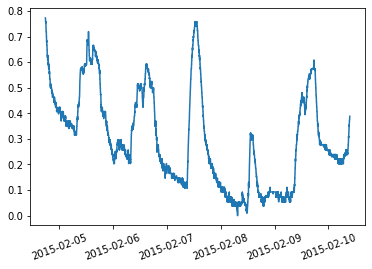

In [17]:
ts_Temperature = df_all_2["Temperature"]
index = pd.date_range(start=ts_Temperature.index[0], end=ts_Temperature.index[len(ts_Temperature)-1], freq='1min')
ts_Temperature = pd.Series(ts_Temperature.values, index)
plt.plot(ts_Temperature)
plt.xticks(rotation=20)
plt.show()

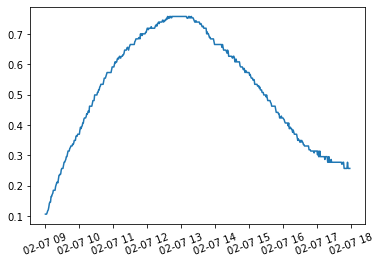

In [18]:
ts_T_Sabato_Half = df_T_Sabato["Temperature"][60*9:60*18]
index = pd.date_range(start=ts_T_Sabato_Half.index[0], end=ts_T_Sabato_Half.index[len(ts_T_Sabato_Half)-1], freq='1min')
ts_T_Sabato_Half = pd.Series(ts_T_Sabato_Half.values[:-1], index)
plt.plot(ts_T_Sabato_Half)
plt.xticks(rotation=20)
plt.show()

Controllo se sono stazionarie

Stazionarietà di : ts_C_Sabato_Quart


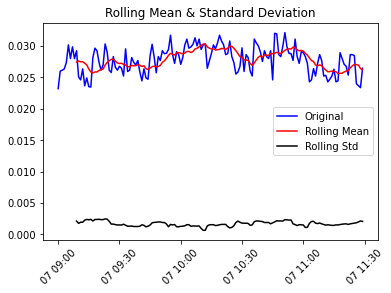

Results of Dickey-Fuller Test:
Test Statistic                  -4.233685
p-value                          0.000578
#Lags Used                       2.000000
Number of Observations Used    147.000000
Critical Value (1%)             -3.475637
Critical Value (5%)             -2.881410
Critical Value (10%)            -2.577365
dtype: float64
Stazionarietà di : ts_C_Giovedi_Halft 


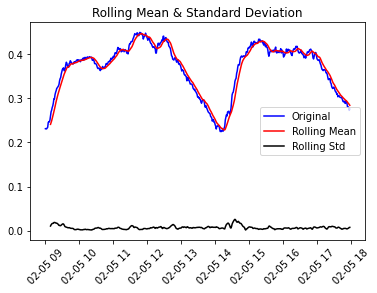

Results of Dickey-Fuller Test:
Test Statistic                  -2.390322
p-value                          0.144487
#Lags Used                      19.000000
Number of Observations Used    519.000000
Critical Value (1%)             -3.443013
Critical Value (5%)             -2.867125
Critical Value (10%)            -2.569745
dtype: float64
Stazionarietà di : ts_Temperature


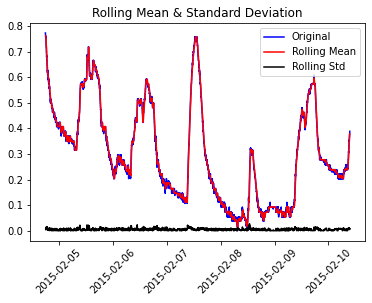

Results of Dickey-Fuller Test:
Test Statistic                   -2.694434
p-value                           0.075006
#Lags Used                       21.000000
Number of Observations Used    8121.000000
Critical Value (1%)              -3.431155
Critical Value (5%)              -2.861896
Critical Value (10%)             -2.566959
dtype: float64
Stazionarietà di : ts_T_Sabato_Half


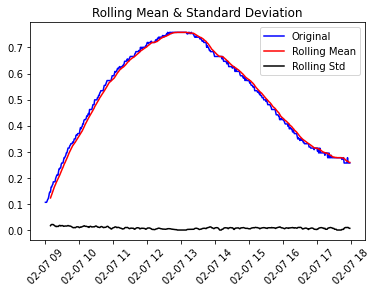

Results of Dickey-Fuller Test:
Test Statistic                  -1.309886
p-value                          0.624637
#Lags Used                      18.000000
Number of Observations Used    520.000000
Critical Value (1%)             -3.442988
Critical Value (5%)             -2.867114
Critical Value (10%)            -2.569739
dtype: float64


In [19]:
print("Stazionarietà di : ts_C_Sabato_Quart")
test_stationarity(ts_C_Sabato_Quart, 10)
print("Stazionarietà di : ts_C_Giovedi_Halft ")
test_stationarity(ts_C_Giovedi_Halft, 10)
print("Stazionarietà di : ts_Temperature")
test_stationarity(ts_Temperature, 10)
print("Stazionarietà di : ts_T_Sabato_Half")
test_stationarity(ts_T_Sabato_Half, 10)


Stazionarietà di : ts_dataset2


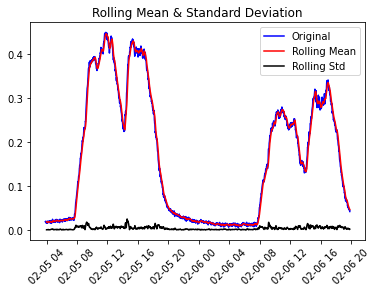

Results of Dickey-Fuller Test:
Test Statistic                   -2.278290
p-value                           0.179066
#Lags Used                       26.000000
Number of Observations Used    2373.000000
Critical Value (1%)              -3.433109
Critical Value (5%)              -2.862759
Critical Value (10%)             -2.567419
dtype: float64
Stazionarietà di : ts_first 


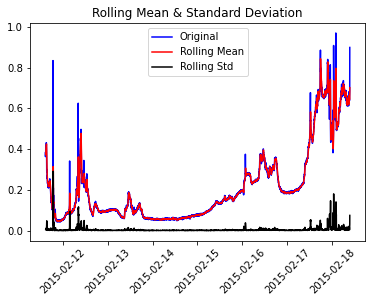

Results of Dickey-Fuller Test:
Test Statistic                   -0.529088
p-value                           0.886214
#Lags Used                       24.000000
Number of Observations Used    9727.000000
Critical Value (1%)              -3.431022
Critical Value (5%)              -2.861837
Critical Value (10%)             -2.566928
dtype: float64
Stazionarietà di : ts_second 


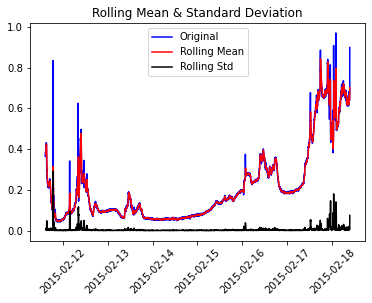

Results of Dickey-Fuller Test:
Test Statistic                   -0.529088
p-value                           0.886214
#Lags Used                       24.000000
Number of Observations Used    9727.000000
Critical Value (1%)              -3.431022
Critical Value (5%)              -2.861837
Critical Value (10%)             -2.566928
dtype: float64


In [20]:
print("Stazionarietà di : ts_dataset2")
test_stationarity(ts_dataset2, 10)
print("Stazionarietà di : ts_first ")
test_stationarity(ts_first, 10)
print("Stazionarietà di : ts_second ")
test_stationarity(ts_second, 10)

9752


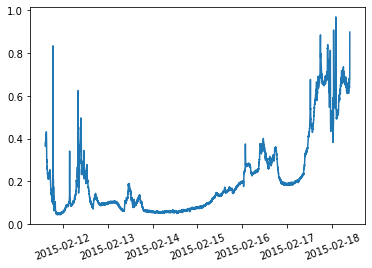

In [21]:
ts_second = df_second['CO2']
print(len(ts_second))
index = pd.date_range(start=ts_second.index[0], end=ts_second.index[len(ts_second)-1], freq='1min')
ts_first = pd.Series(ts_second.values, index)
plt.plot(ts_first)
plt.xticks(rotation=20)
plt.show()

- ts_C_Sabato_Quart: è stazionaria
- ts_dataset2: non è stazionaria
- ts_first : ni
- ts_C_Giovedi_Halft : non è stazionaria
- ts_Temperature: ni
- ts_T_Sabato_Half: no

Stesse cose ma con il test KPSS

In [22]:
print("Stazionarietà di : ts_C_Sabato_Quart")
kpss_test(ts_C_Sabato_Quart)
print("Stazionarietà di : ts_dataset2")
kpss_test(ts_dataset2)
print("Stazionarietà di : ts_first ")
kpss_test(ts_first)
print("Stazionarietà di : ts_C_Giovedi_Halft ")
kpss_test(ts_C_Giovedi_Halft)
print("Stazionarietà di : ts_Temperature")
kpss_test(ts_Temperature)
print("Stazionarietà di : ts_T_Sabato_Half")
kpss_test(ts_T_Sabato_Half)

Stazionarietà di : ts_C_Sabato_Quart
Results of KPSS Test:
Test Statistic            0.213406
p-value                   0.100000
Lags Used                14.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Stazionarietà di : ts_dataset2
Results of KPSS Test:
Test Statistic            0.877263
p-value                   0.010000
Lags Used                27.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Stazionarietà di : ts_first 
Results of KPSS Test:
Test Statistic           13.673278
p-value                   0.010000
Lags Used                38.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Stazionarietà di : ts_C_Giovedi_Halft 
Results of KPSS Te

c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
c:\

- ts_C_Sabato_Quart: è stazionaria
- ts_dataset2: non è stazionaria
- ts_first : non è stazionaria
- ts_C_Giovedi_Halft : è stazionaria
- ts_Temperature: non è stazionaria
- ts_T_Sabato_Half: non è stazionaria

siccome ts_C_Giovedi_Halft è stazionaria solo per il test KPSS la serie è trend stationary: dobbiamo levare il trend

Prova logaritmo: 
Results of KPSS Test:
Test Statistic            0.159116
p-value                   0.100000
Lags Used                19.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Risultati del DIckey-Fuller Test:
Test Statistic                  -2.531226
p-value                          0.108060
#Lags Used                      19.000000
Number of Observations Used    519.000000
Critical Value (1%)             -3.443013
Critical Value (5%)             -2.867125
Critical Value (10%)            -2.569745
dtype: float64


c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


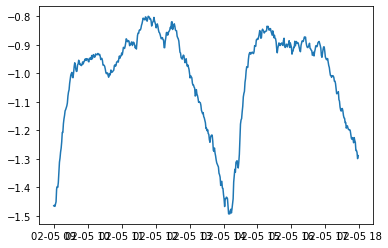

Prova difference: 
Results of KPSS Test:
Test Statistic            0.384528
p-value                   0.083824
Lags Used                19.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Risultati del DIckey-Fuller Test:
Test Statistic                  -3.998928
p-value                          0.001416
#Lags Used                       8.000000
Number of Observations Used    529.000000
Critical Value (1%)             -3.442772
Critical Value (5%)             -2.867019
Critical Value (10%)            -2.569688
dtype: float64


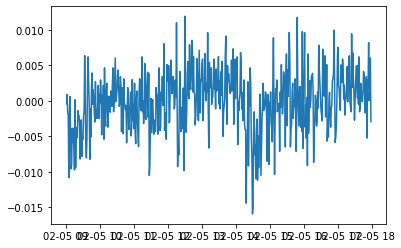

Prova difference: 
Results of KPSS Test:
Test Statistic            0.388646
p-value                   0.082049
Lags Used                19.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Risultati del DIckey-Fuller Test:
Test Statistic                  -3.854049
p-value                          0.002400
#Lags Used                      19.000000
Number of Observations Used    514.000000
Critical Value (1%)             -3.443136
Critical Value (5%)             -2.867179
Critical Value (10%)            -2.569774
dtype: float64


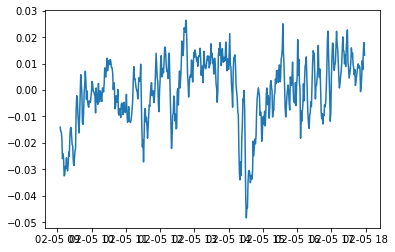

Prova logaritmo - moving 20 min: 


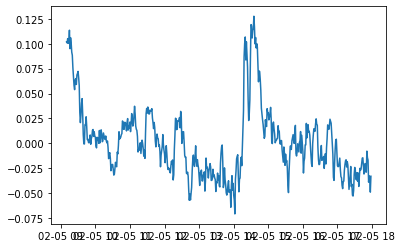

Results of KPSS Test:
Test Statistic            0.34669
p-value                   0.10000
Lags Used                19.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64
Risultati del DIckey-Fuller Test:
Test Statistic                  -3.511913
p-value                          0.007686
#Lags Used                       3.000000
Number of Observations Used    535.000000
Critical Value (1%)             -3.442632
Critical Value (5%)             -2.866957
Critical Value (10%)            -2.569655
dtype: float64


c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [23]:
window = 20
print("Prova logaritmo: ")
ts_log = np.log(ts_C_Giovedi_Halft)
kpss_test(ts_log)
adf_test(ts_log)
plt.plot(ts_log)
plt.show()

print("Prova difference: ")
ts_diff = pd.Series(ts_C_Giovedi_Halft[:-1].values - ts_C_Giovedi_Halft[1:].values, index = ts_C_Giovedi_Halft.index[1:])
kpss_test(ts_diff)
adf_test(ts_diff)
plt.plot(ts_diff)
plt.show()

print("Prova difference: ")
ts_diff5 = pd.Series(ts_C_Giovedi_Halft[:-5].values - ts_C_Giovedi_Halft[5:].values, index = ts_C_Giovedi_Halft.index[5:])
kpss_test(ts_diff5)
adf_test(ts_diff5)
plt.plot(ts_diff5)
plt.show()

print("Prova logaritmo - moving 20 min: ")
ts_log_mov_diff10 = pd.Series(np.log(ts_C_Giovedi_Halft) - np.log(ts_C_Giovedi_Halft).rolling(11, center=False).mean(), index=ts_C_Giovedi_Halft.index)
plt.plot(ts_log_mov_diff10)
plt.show()
#ts_log_mov_diff20[20:]
ts_log_mov_diff10 = ts_log_mov_diff10.fillna(0)
kpss_test(ts_log_mov_diff10)
adf_test(ts_log_mov_diff10)



In [24]:
kpss_test(ts_log_mov_diff10[10:])
adf_test(ts_log_mov_diff10[10:])

Results of KPSS Test:
Test Statistic            0.355011
p-value                   0.096547
Lags Used                19.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Risultati del DIckey-Fuller Test:
Test Statistic                  -3.838626
p-value                          0.002536
#Lags Used                       3.000000
Number of Observations Used    525.000000
Critical Value (1%)             -3.442867
Critical Value (5%)             -2.867061
Critical Value (10%)            -2.569710
dtype: float64


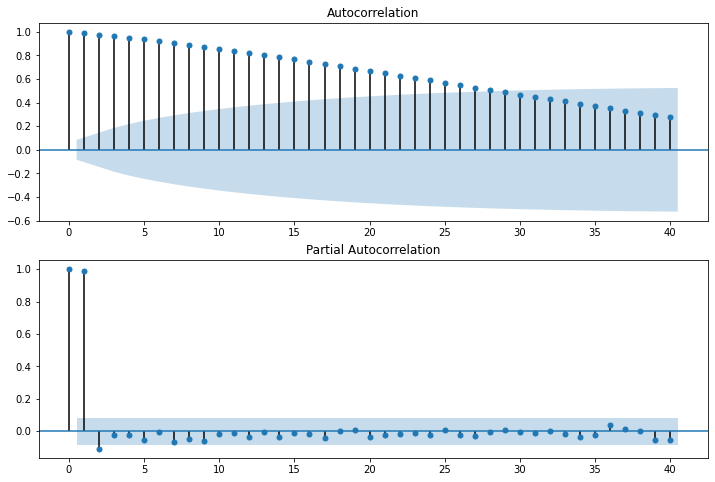

In [33]:
ts = ts_C_Giovedi_Halft
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts.values, lags=40, ax=ax2)

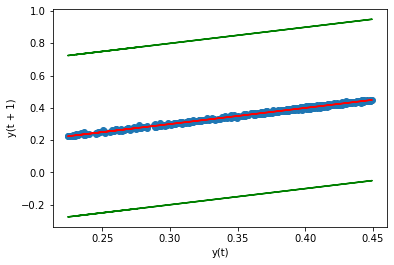

In [34]:
#rcParams['figure.figsize'] = 4,4

from pandas.plotting import lag_plot
lag_plot( ts )
# Plot also some reference lines to highlight strong correlation areas
plt.plot(ts, ts, 'r-')
plt.plot(ts, ts+0.5, 'g-')
plt.plot(ts, ts-0.5, 'g-')

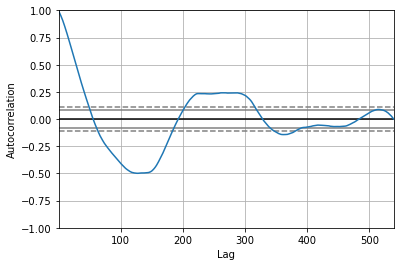

In [35]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(ts)

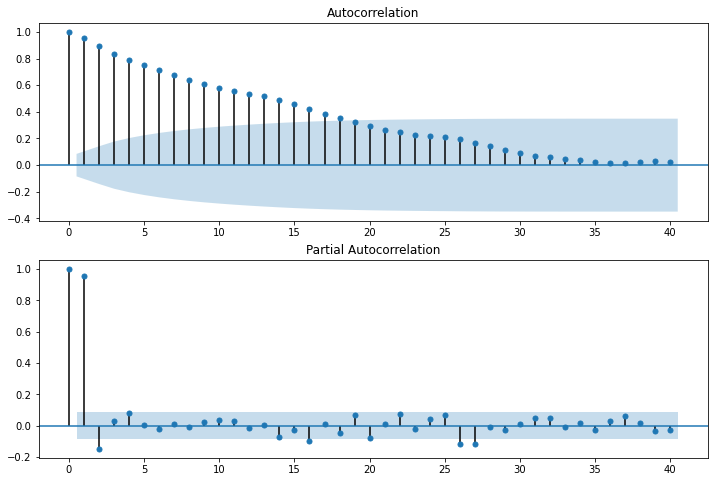

In [26]:
ts = ts_log_mov_diff10
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts.values, lags=40, ax=ax2)

In [472]:
ts = ts_log_mov_diff10[10:]
C_split_index = len(ts) - int((len(ts)*30)/100.0)
train, test = ts.iloc[:C_split_index], ts.iloc[C_split_index:]
par = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
r2 = -10
indexx = (0,0,0)
for i in range(30, 120, 5):
    for j in par:
        for k in par:
            es = ExponentialSmoothing(train, seasonal_periods=i,  trend='add', seasonal='add').fit(smoothing_level=j, smoothing_slope=k)
            pred = es.predict(start=test.index[0], end=test.index[-1])
            rr = r2_score2(test, pred, ts)
            if rr > r2:
                indexx = (i, j, k) 
                r2 = rr

c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
c:\users\matte\

c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  Convergenc

c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  Convergenc

c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  Convergenc

In [473]:
indexx

(40, 0.6, 0.2)

c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


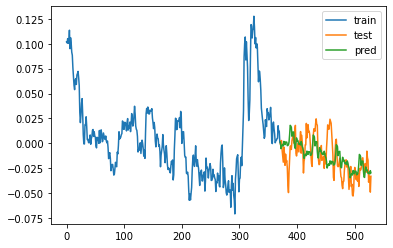

MAE 0.013
RMSE 0.016
MAD 0.010
R2 0.523
MAPE 4.445
MAXAPE 267.166
TAPE 702.380
RealR2 0.227


In [493]:
ts = ts_log_mov_diff10[10:]
C_Sabato_split_index = len(ts) - int((len(ts)*30)/100.0)
train, test = ts.iloc[:C_Sabato_split_index], ts.iloc[C_Sabato_split_index:]

es = ExponentialSmoothing(train, seasonal_periods=40,trend = 'add', seasonal='add').fit(smoothing_level=0.59
                                                                        , smoothing_slope=0.22)
pred = es.predict(start=test.index[0], end=test.index[-1])

plt.plot(range(len(train)), train, label='train')
plt.plot(range(len(train), len(train)+len(test)), test, label='test')
plt.plot(range(len(train), len(train)+len(pred)), pred, label='pred')
plt.legend()
plt.show()

for k, v in evaluate(test, pred, ts).items():
    print('%s %.3f' % (k, v))

c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


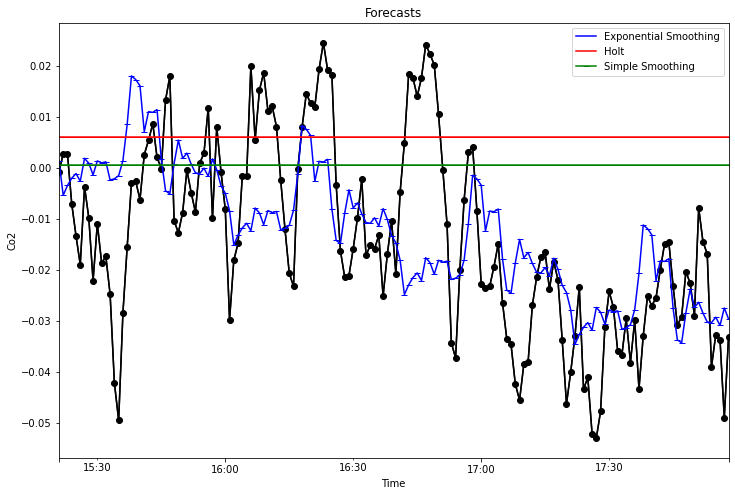

In [513]:
ts = ts_log_mov_diff10[10:]
C_split_index = len(ts) - int((len(ts)*30)/100.0)
train, test = ts.iloc[:C_split_index], ts.iloc[C_split_index:]

# Modello 1
fit1 = ExponentialSmoothing(train, seasonal_periods=40,trend = 'add', seasonal='add').fit(smoothing_level=0.59
                                                                        , smoothing_slope=0.22)
fcast1 = fit1.predict(start=test.index[0], end=test.index[-1]).rename("Exponential Smoothing")


ax = test.plot(figsize=(10,6), marker='o', color='black', title="Forecasts" )

ax.set_ylabel("Co2")
ax.set_xlabel("Time")

fit2 = Holt(train, damped=True).fit(smoothing_level=0.5, smoothing_slope=1.7)
fcast2 = fit2.predict(start=test.index[0], end=test.index[-1]).rename("Holt")

fit3 = SimpleExpSmoothing(train).fit()
fcast3 = fit3.predict(start=test.index[0], end=test.index[-1]).rename("Simple Smoothing")

ax = test.plot(color="black", marker="_", figsize=(12,8))
#fit1.fittedvalues.plot(ax=ax, color='blue')
fcast1.plot(ax=ax, color='blue', marker="_", legend=True)
#fit2.fittedvalues.plot(ax=ax, color='red')
fcast2.plot(ax=ax, color='red', marker="_", legend=True)

fcast3.plot(ax=ax, color='green', marker="_", legend=True)

plt.show()

c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


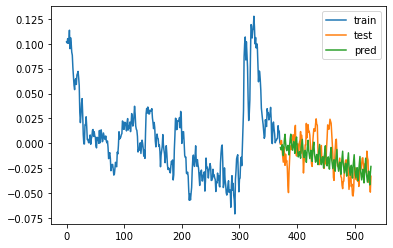

MAE 0.014
RMSE 0.017
MAD 0.011
R2 0.478
MAPE 1.937
MAXAPE 21.857
TAPE 306.044
RealR2 0.155


In [610]:
ts = ts_log_mov_diff10[10:]
C_split_index = len(ts) - int((len(ts)*30)/100.0)
train, test = ts.iloc[:C_split_index], ts.iloc[C_split_index:]
# sarimax = SARIMAX(train, order=(1,0,3), seasonal_order=(1, 2, 3, 10)).fit(disp=False)
#sarimax = SARIMAX(train, order=(1,0,3), seasonal_order=(3, 2, 3, 10)).fit(disp=True, enforce_stationarity=True, enforce_invertibility=True)
sarimax = SARIMAX(train, order=(1,0,3), seasonal_order=(3, 2, 3, 10)).fit(disp=True, enforce_stationarity=True, enforce_invertibility=True)

pred = sarimax.predict(start=test.index[0], end=test.index[-1])

plt.plot(range(len(train)), train, label='train')
plt.plot(range(len(train), len(train)+len(test)), test, label='test')
plt.plot(range(len(train), len(train)+len(pred)), pred, label='pred')
plt.legend()
plt.show()

for k, v in evaluate(test, pred, ts).items():
    print('%s %.3f' % (k, v))

c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


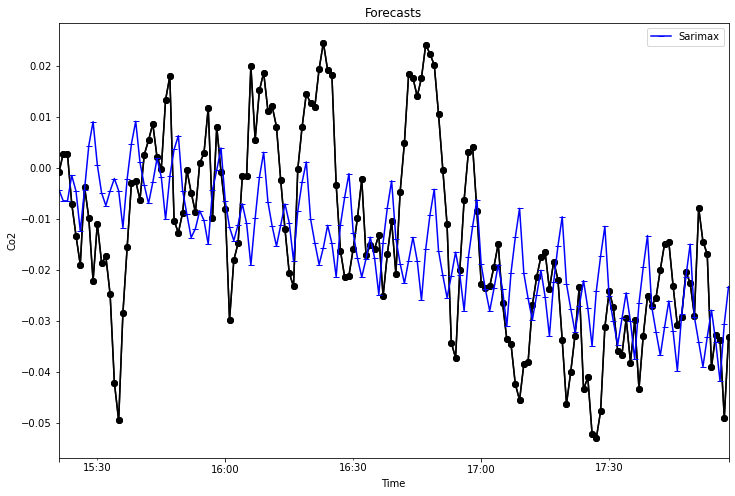

In [614]:
ts = ts_log_mov_diff10[10:]
C_split_index = len(ts) - int((len(ts)*30)/100.0)
train, test = ts.iloc[:C_split_index], ts.iloc[C_split_index:]

fit1 = SARIMAX(train, order=(1,0,3), seasonal_order=(3, 2, 3, 10)).fit(disp=True, enforce_stationarity=True, enforce_invertibility=True)

fcast1 = fit1.predict(start=test.index[0], end=test.index[-1]).rename("Sarimax")


ax = test.plot(figsize=(10,6), marker='o', color='black', title="Forecasts" )

ax.set_ylabel("Co2")
ax.set_xlabel("Time")

ax = test.plot(color="black", marker="o", figsize=(12,8))

fcast1.plot(ax=ax, color='blue', marker="_", legend=True)

plt.show()

c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


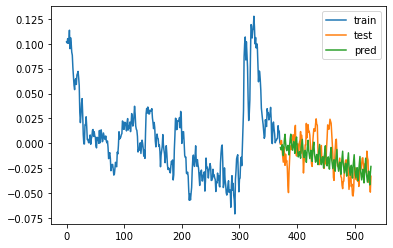

MAE 0.014
RMSE 0.017
MAD 0.011
R2 0.478
MAPE 1.937
MAXAPE 21.857
TAPE 306.044
RealR2 0.155


c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


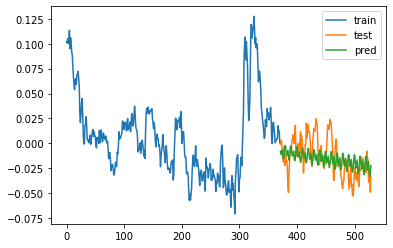

MAE 0.014
RMSE 0.018
MAD 0.011
R2 0.452
MAPE 1.108
MAXAPE 9.601
TAPE 175.054
RealR2 0.112


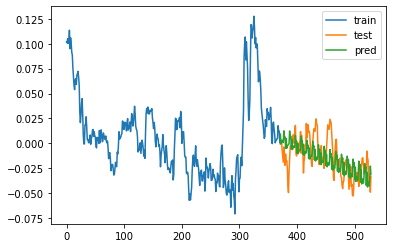

MAE 0.014
RMSE 0.018
MAD 0.011
R2 0.454
MAPE 3.274
MAXAPE 116.477
TAPE 517.365
RealR2 0.116


c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


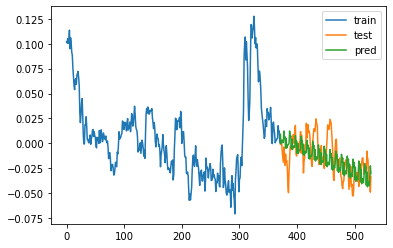

MAE 0.014
RMSE 0.018
MAD 0.011
R2 0.456
MAPE 3.302
MAXAPE 136.180
TAPE 521.735
RealR2 0.119


In [594]:
ts = ts_log_mov_diff10[10:]
C_split_index = len(ts) - int((len(ts)*30)/100.0)
train, test = ts.iloc[:C_split_index], ts.iloc[C_split_index:]
#sarimax = SARIMAX(train, order=(1,0,3), seasonal_order=(3, 2, 4, 10)).fit(disp=True, enforce_stationarity=True, enforce_invertibility=True)

sarimax = SARIMAX(train, order=(1,0,3), seasonal_order=(3, 2, 3, 10)).fit(disp=False)

pred = sarimax.predict(start=test.index[0], end=test.index[-1])

plt.plot(range(len(train)), train, label='train')
plt.plot(range(len(train), len(train)+len(test)), test, label='test')
plt.plot(range(len(train), len(train)+len(pred)), pred, label='pred')
plt.legend()
plt.show()

for k, v in evaluate(test, pred, ts).items():
    print('%s %.3f' % (k, v))

ts = ts_log_mov_diff10[10:]
C_split_index = len(ts) - int((len(ts)*30)/100.0)
train, test = ts.iloc[:C_split_index], ts.iloc[C_split_index:]

sarimax = SARIMAX(train, order=(1,0,3), seasonal_order=(1, 2, 3, 10)).fit(disp=False)

pred = sarimax.predict(start=test.index[0], end=test.index[-1])

plt.plot(range(len(train)), train, label='train')
plt.plot(range(len(train), len(train)+len(test)), test, label='test')
plt.plot(range(len(train), len(train)+len(pred)), pred, label='pred')
plt.legend()
plt.show()

for k, v in evaluate(test, pred, ts).items():
    print('%s %.3f' % (k, v))



sarimax = SARIMAX(train, order=(0,0,0), seasonal_order=(1, 2, 2, 10)).fit(disp=False)
pred = sarimax.predict(start=test.index[0], end=test.index[-1])

plt.plot(range(len(train)), train, label='train')
plt.plot(range(len(train), len(train)+len(test)), test, label='test')
plt.plot(range(len(train), len(train)+len(pred)), pred, label='pred')
plt.legend()
plt.show()

for k, v in evaluate(test, pred, ts).items():
    print('%s %.3f' % (k, v))
    
ts = ts_log_mov_diff10[10:]
C_split_index = len(ts) - int((len(ts)*30)/100.0)
train, test = ts.iloc[:C_split_index], ts.iloc[C_split_index:]

sarimax = SARIMAX(train, order=(0,0,0), seasonal_order=(1, 2, 3, 10)).fit(disp=False)

pred = sarimax.predict(start=test.index[0], end=test.index[-1])

plt.plot(range(len(train)), train, label='train')
plt.plot(range(len(train), len(train)+len(test)), test, label='test')
plt.plot(range(len(train), len(train)+len(pred)), pred, label='pred')
plt.legend()
plt.show()

for k, v in evaluate(test, pred, ts).items():
    print('%s %.3f' % (k, v))